In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
data = pd.read_csv('customer_segmentation.csv')

In [ ]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [ ]:
data['InvoiceYearMonth'] = data['InvoiceDate'].map(lambda date: 100*date.year + date.month)
data.describe()

,Quantity,UnitPrice,CustomerID,InvoiceYearMonth
count,25015.000000,25015.000000,16056.000000,25015.0
mean,7.260284,7.108481,15572.953288,201012.0
std,70.394362,180.950714,1782.224395,0.0
min,-9360.000000,0.000000,12347.000000,201012.0
25%,1.000000,1.450000,14135.000000,201012.0
50%,2.000000,2.510000,15647.500000,201012.0
75%,6.000000,4.250000,17223.000000,201012.0
max,2880.000000,13541.330000,18269.000000,201012.0


In [ ]:
data['Country'].value_counts()

United Kingdom     23709
Germany              309
France               287
EIRE                 228
Norway               147
Portugal              94
Spain                 45
Lithuania             35
Iceland               31
Italy                 25
Australia             22
Denmark               20
Channel Islands       17
Japan                 17
Belgium               12
Poland                 8
Switzerland            6
Netherlands            2
United                 1
Name: Country, dtype: int64

In [ ]:
uk = data.query("Country=='United Kingdom'").reset_index(drop=True)

In [ ]:
user = pd.DataFrame(data['CustomerID'].unique())
user.columns = ['CustomerID']
user.head()

,CustomerID
0,17850.0
1,13047.0
2,12583.0
3,13748.0
4,15100.0


In [ ]:
uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012


In [ ]:
max_purchase = uk.groupby('CustomerID').InvoiceDate.max().reset_index()
max_purchase.columns = ['CustomerID','MaxPurchaseDate']
max_purchase.head()

,CustomerID,MaxPurchaseDate
0,12747.0,2010-12-05 15:38:00
1,12748.0,2010-12-10 12:58:00
2,12826.0,2010-12-09 15:21:00
3,12838.0,2010-12-01 11:57:00
4,12839.0,2010-12-07 15:48:00


In [ ]:
max_purchase['Recency'] = (max_purchase['MaxPurchaseDate'].max() - max_purchase['MaxPurchaseDate']).dt.days
max_purchase.head()

,CustomerID,MaxPurchaseDate,Recency
0,12747.0,2010-12-05 15:38:00,4
1,12748.0,2010-12-10 12:58:00,0
2,12826.0,2010-12-09 15:21:00,0
3,12838.0,2010-12-01 11:57:00,9
4,12839.0,2010-12-07 15:48:00,2


In [ ]:
user = pd.merge(user, max_purchase[['CustomerID','Recency']], on='CustomerID')
user.head()

,CustomerID,Recency
0,17850.0,7
1,13047.0,9
2,13748.0,9
3,15100.0,2
4,15291.0,9


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

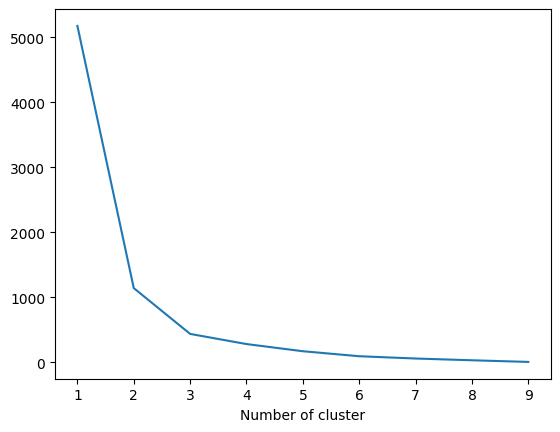

In [ ]:
from sklearn.cluster import KMeans

sse={} # error
recency = user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(recency)
    recency["clusters"] = kmeans.labels_  #cluster names corresponding to recency values
    sse[k] = kmeans.inertia_ #sse corresponding to clusters
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()